In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import Util


In [2]:
# Import Data Frame and view data
df = pd.read_csv('hungary_chickenpox.csv',sep=',')
df

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,01/12/2014,95,12,41,6,39,0,16,15,14,...,56,7,13,122,4,23,4,11,110,10
518,08/12/2014,43,39,31,10,34,3,2,30,25,...,34,20,18,70,36,5,23,22,63,9
519,15/12/2014,35,7,15,0,0,0,7,7,4,...,30,36,4,72,5,21,14,0,17,10
520,22/12/2014,30,23,8,0,11,4,1,9,10,...,27,17,21,12,5,17,1,1,83,2


Preprocess Data

In [3]:
df = df.drop(columns = ['Date'])

In [4]:
# sns.pairplot(df)

In [5]:
class Discriminator(nn.Module):
    # Classifies data as real or synthetic, used to train generator
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size*8)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*8), (batch_size*4)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*4), (batch_size*2)),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear((batch_size*2), 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    


In [6]:
class Generator(nn.Module):
    # Generates synthetic data
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(df_dim, (batch_size)),
            nn.ReLU(),
            nn.Linear((batch_size), (batch_size*2)),
            nn.ReLU(),
            nn.Linear((batch_size*2), df_dim),
        )

    def forward(self, x):
        output = self.model(x)
        return output



In [7]:
def training_loop(num_epochs, train_loader, lr=0.002):
# This is where the generator and discrimator are trained
    # loss function
    loss_function = nn.BCELoss()
    # Optimizer
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    for epoch in range(num_epochs):

        for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator
            real_samples_labels = torch.ones((batch_size, 1))
            latent_space_samples = torch.randn((batch_size, df_dim))
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Data for training the generator
            latent_space_samples = torch.randn((batch_size, df_dim))

        # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()
        # Show loss
            if epoch % 10 == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [8]:
# Get column names
names = Util.get_column_names(df)

In [9]:
# Set random state
torch.manual_seed(111)
# Select # of data points from data set to train GAN
num_data = 500
# Specify dimensionality of dataframe
df_dim = len(df.columns)
# learning rate
lr = 0.003
# number of epoch
num_epochs = 1000
# Discriminator dropout
drop_out=0.2
# Define batch size for the data loader
batch_size = 25


# These create the arrays and then turns them into tensors for the train loader 
arrays = Util.create_arrays(df,num_data)
train_set = Util.create_tensors(arrays)

discriminator = Discriminator()
generator = Generator()

In [10]:
# Specify Time window for time step input
window = batch_size
num_samples = int(num_data / window)
array_edges = torch.tensor(np.arange(1,num_data,window))

In [11]:
# This makes bins of tensors to feed into the training function
tensor_pieces = []
for i in range(0, len(train_set), window):
    # Add the next 5 tuples as a list to the new list
    tensor_pieces.append(list(train_set[i:i+window]))

In [12]:
# The train loader loads the data into the neural network trainer
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

Train the model using either time steps or single input by uncommenting one and commenting the other

In [13]:
# This takes time steps as inputs

# n = len(tensor_pieces)
# for i in range(n):
#     train_loader = torch.utils.data.DataLoader(tensor_pieces[0], batch_size=batch_size)
#     training_loop(num_epochs, train_loader, lr)
    
#     latent_space_samples = torch.randn((batch_size), df_dim)
#     generated_samples = generator(latent_space_samples)
#     generated_samples = generated_samples.detach()
#     df_gen=pd.DataFrame(generated_samples)
#     df_gen = df_gen.set_axis(names, axis=1, inplace=False)   
#     df1=df_gen[names[0]]
#     df1.plot(x=df1.index)

In [14]:
# This takes the entire dataframe as input
training_loop(num_epochs, train_loader, lr)

In [15]:
# After training the Gen, generates data as tensors
latent_space_samples = torch.randn((num_data), df_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

In [16]:
# Takes the generated data and turns it into a pandas DataFrame
df_gen=pd.DataFrame(generated_samples)
df_gen = df_gen.set_axis(names, axis=1, inplace=False)


<AxesSubplot: >

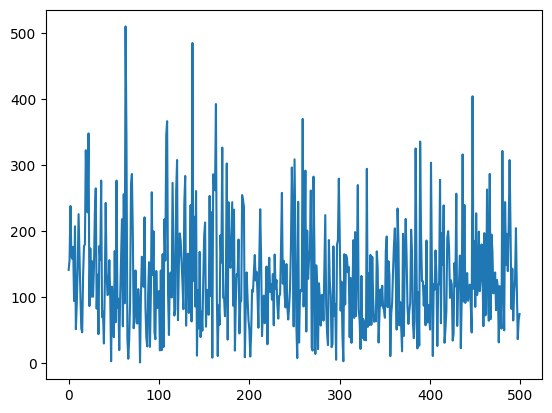

In [17]:
# This is what the Generated time series looks like
df1=df_gen[names[0]]
df1.plot(x=df1.index)

<AxesSubplot: >

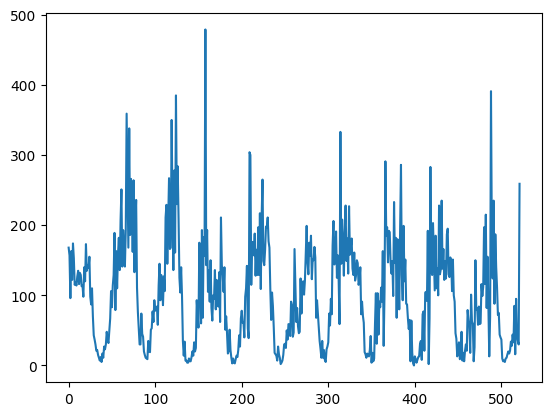

In [18]:
# This is what the real data time series looks like
df2=df[names[0]].astype(float)
df2.plot(x=df1.index)

In [19]:
# sns.pairplot(df_gen)

Text(0.5, 1.0, 'Real vs Generated Data')

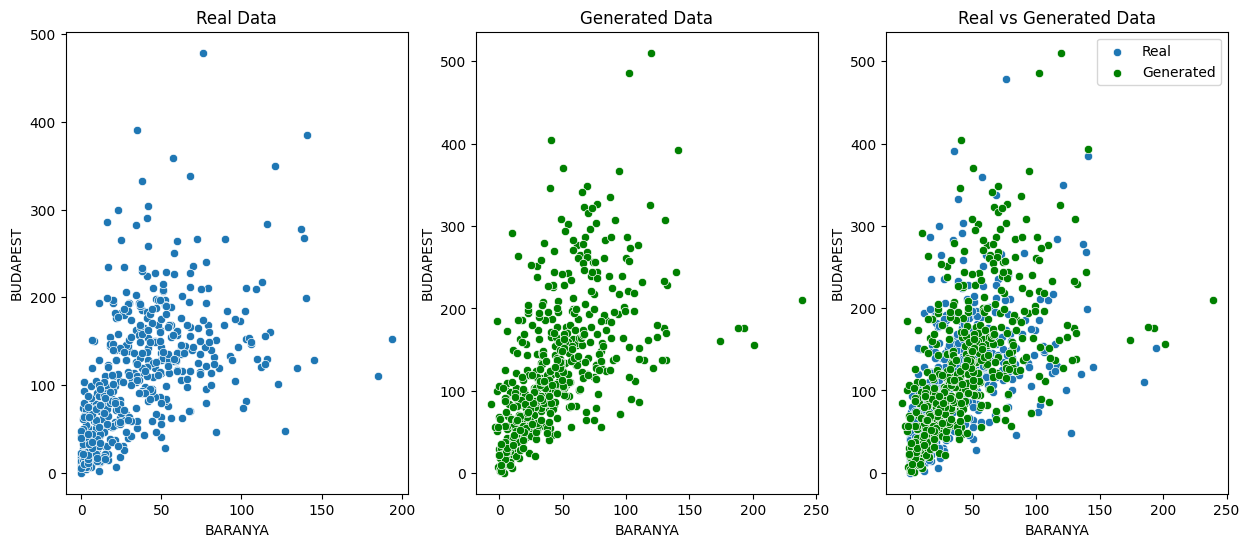

In [20]:
# Plotting Real vs Generated data
fig, axes = plt.subplots(1, 3, figsize=(15, 6))


sns.scatterplot(ax=axes[0],x=names[1], y=names[0], data=df)
axes[0].set_title('Real Data')

sns.scatterplot(ax=axes[1], data=df_gen,x=names[1], y=df_gen[names[0]], color='g')
axes[1].set_title('Generated Data')

sns.scatterplot(ax=axes[2], data=df, x=names[1], y=names[0], label='Real')
sns.scatterplot(ax=axes[2], data=df_gen, x=names[1], y=names[0], color='g', label= 'Generated')
axes[2].set_title('Real vs Generated Data')


In [21]:
# n = len(tensor_pieces)
# for i in range(n):
#     train_loader = torch.utils.data.DataLoader(tensor_pieces[0], batch_size=batch_size)
#     training_loop(num_epochs, train_loader, lr)
    
#     latent_space_samples = torch.randn((batch_size), df_dim)
#     generated_samples = generator(latent_space_samples)
#     generated_samples = generated_samples.detach()
#     df_gen=pd.DataFrame(generated_samples)
#     df_gen = df_gen.set_axis(names, axis=1, inplace=False)
#     sns.scatterplot(data=df_gen,x=names[1], y=df_gen[names[0]], color='g')

# sns.scatterplot(x=names[1], y=names[0], data=df)

In [22]:
print('Current Model Parameters:')
print('Size of dataset:', num_data)
print('Number of epochs:', num_epochs)
print('Learning Rate:', lr)
print('Discriminator dropout:', drop_out)
print('Batch Size:', batch_size)

Current Model Parameters:
Size of dataset: 500
Number of epochs: 1000
Learning Rate: 0.003
Discriminator dropout: 0.2
Batch Size: 25
